In [1]:
# # Mount GDrive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# # Put Colab in the context of this challenge
# import os

# # os.chdir allows you to change directories, like cd in the Terminal
# os.chdir('/content/drive/MyDrive/Colab Notebooks/sign-language-interpretation')

In [13]:
%load_ext autoreload
%autoreload 

In [1]:
import matplotlib.pyplot as plotter_lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL as image_lib
import tensorflow as tflow
from tensorflow.keras.layers import Flatten
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# from keras.applications.vgg19 import VGG19
from keras.models import Model, Sequential
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
%matplotlib inline
import os
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import random
import cv2
from tensorflow.keras.utils import image_dataset_from_directory

2023-05-28 17:22:38.508969: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-28 17:22:38.933924: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-28 17:22:38.939969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 17:22:40.938829: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Prep with flow_from_dataframe()

In [8]:
# Set the function to load the input images
def load_image_dataset_v2(root_directory, image_size, batch_size, validate_size, test_size):
    # Set the intial DataFrame map
    image_paths = []
    image_labels = []
    letters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12,
                'O':13, 'P':14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19, 'V':20, 'W':21, 'X':22, 'Y':23}
    class_names = letters.values()

    # Traverse the directory tree
    for root, dirs, files in os.walk(root_directory):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png"):  # Modify the extensions if necessary
                image_path = os.path.join(root, file)
                image_paths.append(image_path)
                image_labels.append(str(letters[file.split('_')[0]]))
    
    # Create a DataFrame from the collected data
    image_map = {
        'Image_Path': image_paths,
        'Label': image_labels}

    # Shuffle the DataFrame datasets
    df = pd.DataFrame(image_map).sample(frac=1).reset_index(drop=True)
    print(df)
    
    # Split the data into train and test/validation sets
    train_df, test_df = train_test_split(df, test_size=validate_size+test_size, random_state=42)
    val_df, test_df = train_test_split(test_df, test_size=test_size/(validate_size+test_size), random_state=42)

    # Create a data generator
    datagen = tflow.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    # Load the image dataset
    image_train = datagen.flow_from_dataframe(
                        dataframe=train_df,
                        x_col=df.columns[0],
                        y_col=df.columns[1],
                        target_size=image_size,
                        batch_size=batch_size,
                        shuffle=True,
                        classes=class_names)  # Set the class names explicitly
    
    image_val = datagen.flow_from_dataframe(
                        dataframe=val_df,
                        x_col=df.columns[0],
                        y_col=df.columns[1],
                        target_size=image_size,
                        batch_size=batch_size,
                        shuffle=False,
                        classes=class_names)  # Set the class names explicitly
    
    image_test = datagen.flow_from_dataframe(
                    dataframe=test_df,
                    x_col=df.columns[0],
                    y_col=df.columns[1],
                    target_size=image_size,
                    batch_size=batch_size,
                    shuffle=False,
                    classes=class_names)  # Set the class names explicitly
    
    return image_train, image_val, image_test

root_directory = os.path.join("raw_data", "landmark_train_data")  # Replace with the root directory path
image_size = (200, 200)
batch_size = 32
validate_size = 0.2   # Set =0 if NO validation data output 
test_size = 0.1       # Set =0 if No test data output

train_data_v2, val_data_v2, test_data_v2 = load_image_dataset_v2(root_directory, image_size, batch_size, validate_size, test_size)

                                     Image_Path Label
0      raw_data/landmark_train_data/H/H_513.jpg     7
1       raw_data/landmark_train_data/D/D_16.jpg     3
2      raw_data/landmark_train_data/T/T_640.jpg    18
3       raw_data/landmark_train_data/O/O_53.jpg    13
4      raw_data/landmark_train_data/D/D_180.jpg     3
...                                         ...   ...
19194  raw_data/landmark_train_data/S/S_358.jpg    17
19195  raw_data/landmark_train_data/K/K_247.jpg     9
19196  raw_data/landmark_train_data/B/B_550.jpg     1
19197  raw_data/landmark_train_data/O/O_573.jpg    13
19198  raw_data/landmark_train_data/C/C_147.jpg     2

[19199 rows x 2 columns]
Found 0 validated image filenames belonging to 24 classes.
Found 0 validated image filenames belonging to 24 classes.
Found 0 validated image filenames belonging to 24 classes.


In [12]:
# Get the class names
class_names_train = train_data_v2.class_indices
class_names_val = val_data_v2.class_indices
class_names_test = test_data_v2.class_indices

# Print the class names
print("Class Names:")
# for class_name, class_index in class_names_train.items():
#     print(f"Train Data Class Index: {class_index}, Class Name: {class_name}")
print(class_names_train)
print(class_names_val)
print(class_names_test)
#assert class_names_train == class_names_val == class_names_test, "Train, test, and validation labels are not the same."


Class Names:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23}


In [11]:
for class_name, class_index in class_names_val.items():
    print(f"Validate Data Class Index: {class_index}, Class Name: {class_name}")

Validate Data Class Index: 0, Class Name: 0
Validate Data Class Index: 1, Class Name: 1
Validate Data Class Index: 2, Class Name: 2
Validate Data Class Index: 3, Class Name: 3
Validate Data Class Index: 4, Class Name: 4
Validate Data Class Index: 5, Class Name: 5
Validate Data Class Index: 6, Class Name: 6
Validate Data Class Index: 7, Class Name: 7
Validate Data Class Index: 8, Class Name: 8
Validate Data Class Index: 9, Class Name: 9
Validate Data Class Index: 10, Class Name: 10
Validate Data Class Index: 11, Class Name: 11
Validate Data Class Index: 12, Class Name: 12
Validate Data Class Index: 13, Class Name: 13
Validate Data Class Index: 14, Class Name: 14
Validate Data Class Index: 15, Class Name: 15
Validate Data Class Index: 16, Class Name: 16
Validate Data Class Index: 17, Class Name: 17
Validate Data Class Index: 18, Class Name: 18
Validate Data Class Index: 19, Class Name: 19
Validate Data Class Index: 20, Class Name: 20
Validate Data Class Index: 21, Class Name: 21
Validate

## Data Prep with image_dataset_from_directory()

In [2]:
def load_image_dataset(root_directory, image_size, batch_size, validate_size):
    # Set the intial DataFrame map
    letters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12,
                'O':13, 'P':14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19, 'V':20, 'W':21, 'X':22, 'Y':23}

    # Create a data generator
    #datagen = tflow.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=validate_size)
    
    # Load the image dataset
    train_ds = image_dataset_from_directory(
                        root_directory,
                        labels = "inferred",
                        label_mode = "categorical",
                        image_size = image_size,
                        validation_split = validate_size,
                        subset = "training",
                        batch_size = batch_size,
                        seed = 0,
                        shuffle = True)
    val_ds = image_dataset_from_directory(
                        root_directory,
                        labels = "inferred",
                        label_mode = "categorical",
                        image_size = image_size,
                        validation_split = validate_size,
                        subset = "validation",
                        batch_size = batch_size,
                        seed = 0,
                        shuffle = True)
    
    val_batches = len(val_ds)
    test_ds = val_ds.take((1*val_batches) // 6)
    val_ds = val_ds.skip((1*val_batches) // 6)
    print(f'val_batches:{val_batches}')
    
    return train_ds, val_ds, test_ds

root_directory = os.path.join("raw_data", "landmark_train_data")  # Replace with the root directory path
image_size = (200, 200)
batch_size = 32
validate_size = 0.3   # Set =0 if NO validation data output 

train_data, val_data, test_data = load_image_dataset(root_directory, image_size, batch_size, validate_size)

Found 19199 files belonging to 24 classes.
Using 13440 files for training.
Found 19199 files belonging to 24 classes.
Using 5759 files for validation.
val_batches:180


In [16]:
len(train_data), len(val_data), len(test_data)

(420, 150, 30)

In [25]:
root_directory = os.path.join("raw_data", "landmark_train_data")  # Replace with the root directory path
image_size = (100, 100)
batch_size = 32
validate_size = 0.3   # Set =0 if NO validation data output 

train_data_100, val_data_100, test_data_100 = load_image_dataset(root_directory, image_size, batch_size, validate_size)

Found 19199 files belonging to 24 classes.
Using 13440 files for training.
Found 19199 files belonging to 24 classes.
Using 5759 files for validation.
val_batches:180


In [24]:
attributes = train_data.__dict__
for attribute, value in attributes.items():
    print(attribute, ":", value)

_input_dataset : <_ShuffleDataset element_spec=(TensorSpec(shape=(200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(24,), dtype=tf.float32, name=None))>
_batch_size : tf.Tensor(32, shape=(), dtype=int64)
_drop_remainder : tf.Tensor(False, shape=(), dtype=bool)
_structure : (TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24), dtype=tf.float32, name=None))
_name : None
_variant_tensor_attr : tf.Tensor(<BatchDatasetV2Op(32)::Dataset>, shape=(), dtype=variant)
_graph_attr : <tensorflow.python.framework.ops.Graph object at 0x7fa144714df0>
_options_attr : <tensorflow.python.data.ops.options.Options object at 0x7fa0a5625bb0>
class_names : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
file_paths : ['raw_data/landmark_train_data/T/T_169.jpg', 'raw_data/landmark_train_data/G/G_441.jpg', 'raw_data/landmark_train_data/N/N_577.jpg', 'raw_data/landmark_train_data/S/S_55

In [41]:
train_data.__dict__

{'_input_dataset': <_ShuffleDataset element_spec=(TensorSpec(shape=(200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(24,), dtype=tf.float32, name=None))>,
 '_batch_size': <tf.Tensor: shape=(), dtype=int64, numpy=32>,
 '_drop_remainder': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 '_structure': (TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)),
 '_name': None,
 '_variant_tensor_attr': <tf.Tensor: shape=(), dtype=variant, value=<BatchDatasetV2Op(32)::Dataset>>,
 '_graph_attr': <tensorflow.python.framework.ops.Graph at 0x7fa144714df0>,
 '_options_attr': <tensorflow.python.data.ops.options.Options at 0x7fa0a5625bb0>,
 'class_names': ['A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'K',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'X',
  'Y'],
 'file_paths': ['raw_data/landmark_train_data/T/T_169.jpg',
  'raw_data/landmark_train_data/G/G_4

In [3]:
# Input mixed of ASL datasets & SLB samples
root_directory = os.path.join("raw_data", "landmark_train_data_mixed")  # Replace with the root directory path
image_size = (100, 100)
batch_size = 32
validate_size = 0.3  

train_data_100m, val_data_100m, test_data_100m = load_image_dataset(root_directory, image_size, batch_size, validate_size)

Found 78888 files belonging to 24 classes.
Using 55222 files for training.
Found 78888 files belonging to 24 classes.
Using 23666 files for validation.
val_batches:740


In [4]:
len(train_data_100m), len(val_data_100m), len(test_data_100m)

(1726, 617, 123)

## Model Initialization with Pre-trained Model VGG16

In [5]:
def initiliaze_model_vgg16(image_width, image_height, no_chans, n_classes):
    
    #Initialising vgg16 
    classifier_vgg16 = VGG16(input_shape= (image_width,image_height,no_chans),include_top=False,weights='imagenet')
    # classifier_vgg16 = VGG16(include_top=False,weights='imagenet')
    
    #Don't train existing weights for vgg16
    for layer in classifier_vgg16.layers:
        layer.trainable = False

    # Create a new model with the scaling preprocessing function
    input_shape = (image_width,image_height,no_chans)
    inputs = tflow.keras.Input(shape=input_shape)
    
    # Scale input tensor x using VGG16's preprocess_input function
    x = tflow.keras.applications.vgg16.preprocess_input(inputs)
    
    #Add other layers for pre-trained model    
    classifier = classifier_vgg16(x) #head mode
    classifier = Flatten()(classifier) #adding layer of flatten
    classifier = Dense(units=512, activation='relu')(classifier)
    classifier = Dense(units=256, activation='relu')(classifier)
    classifier = Dense(units=128, activation='relu')(classifier)
    classifier = Dropout(0.6)(classifier)
    classifier = Dense(units=n_classes, activation='softmax')(classifier)

    #Build & compile the model
    model = Model(inputs = inputs , outputs = classifier)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

## Show the GPU Setup

In [ ]:
# !pip install tensorflow-gpu
# import tensorflow as tf

# # Prepare your data and define your model architecture

# # Set up GPU configuration
# gpu_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu_devices[0], True)  # Enable memory growth to avoid GPU memory errors

# with tf.device('/GPU:0'):  # Specify the GPU device for training
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     model.fit(train_data, train_labels, epochs=10, batch_size=32)

In [35]:
es = EarlyStopping(patience=5, restore_best_weights=True)

model_vgg16_100 = initiliaze_model_vgg16(100, 100, 3, 24)

epochs = 10

history_vgg16_100 = model_vgg16_100.fit(
                    train_data_100,
                    validation_data = val_data_100,
                    epochs=epochs,
                    callbacks=[es],
                    verbose=1)

Epoch 1/10


2023-05-27 13:40:11.939440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [13440]
	 [[{{node Placeholder/_0}}]]
2023-05-27 13:40:11.940285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13440]
	 [[{{node Placeholder/_4}}]]


420/420 [==============================] - ETA: 0s - loss: 2.1057 - accuracy: 0.4202

2023-05-27 13:48:56.154514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5759]
	 [[{{node Placeholder/_4}}]]
2023-05-27 13:48:56.155393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5759]
	 [[{{node Placeholder/_4}}]]


420/420 [==============================] - 697s 2s/step - loss: 2.1057 - accuracy: 0.4202 - val_loss: 0.5576 - val_accuracy: 0.8285
Epoch 2/10
420/420 [==============================] - 696s 2s/step - loss: 0.8951 - accuracy: 0.7080 - val_loss: 0.2906 - val_accuracy: 0.8900
Epoch 3/10
420/420 [==============================] - 733s 2s/step - loss: 0.5602 - accuracy: 0.8170 - val_loss: 0.2687 - val_accuracy: 0.9108
Epoch 4/10
420/420 [==============================] - 706s 2s/step - loss: 0.3643 - accuracy: 0.8883 - val_loss: 0.1690 - val_accuracy: 0.9552
Epoch 5/10
420/420 [==============================] - 711s 2s/step - loss: 0.2609 - accuracy: 0.9263 - val_loss: 0.5365 - val_accuracy: 0.9337
Epoch 6/10
420/420 [==============================] - 781s 2s/step - loss: 0.2025 - accuracy: 0.9425 - val_loss: 0.1687 - val_accuracy: 0.9552
Epoch 7/10
420/420 [==============================] - 709s 2s/step - loss: 0.1937 - accuracy: 0.9486 - val_loss: 0.1486 - val_accuracy: 0.9706
Epoch 8/10

In [42]:
model_vgg16_100_scores = model_vgg16_100.evaluate(test_data_100)

print(f'VGG16 Test loss: {model_vgg16_100_scores[0]:.4f}')
print(f'VGG16 Test accuracy: {model_vgg16_100_scores[1]:.4f}')

30/30 [==============================] - 28s 943ms/step - loss: 0.1000 - accuracy: 0.9771
VGG16 Test loss: 0.1000
VGG16 Test accuracy: 0.9771


In [37]:
# Save the model
models.save_model(model_vgg16_100, "raw_data/transfer_models/model_vgg16_100_landmark")

2023-05-27 15:42:42.075543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-05-27 15:42:45.049883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: raw_data/transfer_models/model_vgg16_100_landmark/assets


INFO:tensorflow:Assets written to: raw_data/transfer_models/model_vgg16_100_landmark/assets


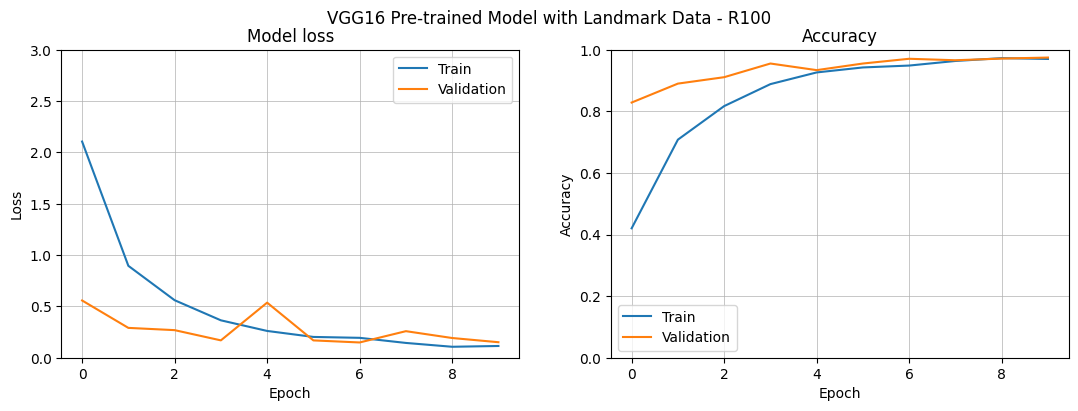

In [39]:
plot_loss_accuracy(history_vgg16_100, 'VGG16 Pre-trained Model with Landmark Data - R100')

In [19]:
# VGG16 pre-trained model with input pixel size 200x200
es = EarlyStopping(patience=5, restore_best_weights=True)

model_vgg16_200 = initiliaze_model_vgg16(200, 200, 3, 24)

epochs = 6

history_vgg16_200 = model_vgg16_200.fit(
                    train_data,
                    validation_data = val_data,
                    epochs=epochs,
                    callbacks=[es],
                    verbose=1)

Epoch 1/6


2023-05-28 11:28:01.290048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [13440]
	 [[{{node Placeholder/_0}}]]
2023-05-28 11:28:01.290960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [13440]
	 [[{{node Placeholder/_0}}]]


420/420 [==============================] - ETA: 0s - loss: 2.3472 - accuracy: 0.4430

2023-05-28 12:03:05.841852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5759]
	 [[{{node Placeholder/_4}}]]
2023-05-28 12:03:05.843237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5759]
	 [[{{node Placeholder/_4}}]]


420/420 [==============================] - 2782s 7s/step - loss: 2.3472 - accuracy: 0.4430 - val_loss: 0.5298 - val_accuracy: 0.8648
Epoch 2/6
420/420 [==============================] - 2741s 7s/step - loss: 0.9309 - accuracy: 0.7012 - val_loss: 0.2578 - val_accuracy: 0.9125
Epoch 3/6
420/420 [==============================] - 3453s 8s/step - loss: 0.6537 - accuracy: 0.7978 - val_loss: 0.2322 - val_accuracy: 0.9221
Epoch 4/6
420/420 [==============================] - 3431s 8s/step - loss: 0.4526 - accuracy: 0.8585 - val_loss: 0.1953 - val_accuracy: 0.9477
Epoch 5/6
420/420 [==============================] - 3542s 8s/step - loss: 0.3651 - accuracy: 0.8838 - val_loss: 0.3350 - val_accuracy: 0.9542
Epoch 6/6
420/420 [==============================] - 2854s 7s/step - loss: 0.3090 - accuracy: 0.9100 - val_loss: 0.1405 - val_accuracy: 0.9756


In [20]:
model_vgg16_200_scores = model_vgg16_200.evaluate(test_data)

print(f'VGG16 Test loss: {model_vgg16_200_scores[0]:.4f}')
print(f'VGG16 Test accuracy: {model_vgg16_200_scores[1]:.4f}')

2023-05-28 16:41:46.498155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5759]
	 [[{{node Placeholder/_0}}]]
2023-05-28 16:41:46.502248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5759]
	 [[{{node Placeholder/_4}}]]


30/30 [==============================] - 163s 5s/step - loss: 0.1164 - accuracy: 0.9771
VGG16 Test loss: 0.1164
VGG16 Test accuracy: 0.9771


2023-05-28 16:44:45.953280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-05-28 16:44:47.641002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: raw_data/transfer_models/model_vgg16_200_landmark/assets


INFO:tensorflow:Assets written to: raw_data/transfer_models/model_vgg16_200_landmark/assets


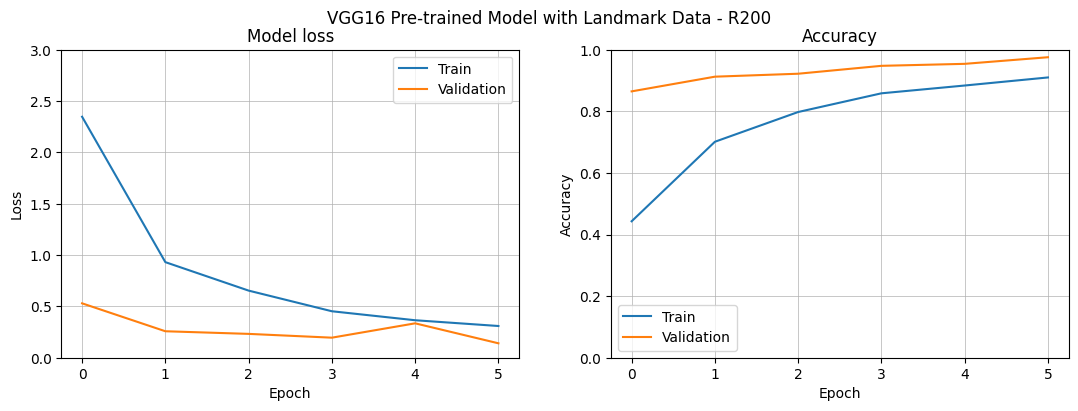

In [23]:
# Save the model
models.save_model(model_vgg16_200, "raw_data/transfer_models/model_vgg16_200_landmark")
plot_loss_accuracy(history_vgg16_200, 'VGG16 Pre-trained Model with Landmark Data - R200')

In [22]:
def plot_loss_accuracy(history, suptitle):
    # Setting figures
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    # Create the plots
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    # Set titles and labels
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    # Set limits for y-axes
    ax1.set_ylim(ymin=0, ymax=3)
    ax2.set_ylim(ymin=0, ymax=1)

    # Generate legends
    ax1.legend(['Train', 'Validation'], loc='best')
    ax2.legend(['Train', 'Validation'], loc='best')
    # Show grids
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)
    
    # Set supertitle
    plt.suptitle(suptitle)
    plt.show()
    
    return

In [ ]:
# root_directory = "raw_data/asl_alphabet_test"  # Replace with the root directory path
# image_test_paths = []
# labels_test = []

# for f in os.listdir(root_directory):
#     if f.endswith('.jpg'): 
#         image_test_paths.append(os.path.join(root_directory, f))
#         labels_test.append(str(letters[f.split('_')[0]]))

# # Create a DataFrame from the collected data
# image_test = {
#     'Image_Path': image_test_paths,
#     'Label': labels_test}

# df_test = pd.DataFrame(image_test)
# # Print the DataFrame
# print(df_test)

                                     Image_Path Label
0         raw_data/asl_alphabet_test/J_test.jpg     9
1         raw_data/asl_alphabet_test/B_test.jpg     1
2         raw_data/asl_alphabet_test/F_test.jpg     5
3         raw_data/asl_alphabet_test/L_test.jpg    11
4         raw_data/asl_alphabet_test/U_test.jpg    20
5     raw_data/asl_alphabet_test/space_test.jpg    26
6         raw_data/asl_alphabet_test/N_test.jpg    13
7         raw_data/asl_alphabet_test/K_test.jpg    10
8         raw_data/asl_alphabet_test/Z_test.jpg    25
9         raw_data/asl_alphabet_test/X_test.jpg    23
10        raw_data/asl_alphabet_test/C_test.jpg     2
11        raw_data/asl_alphabet_test/Q_test.jpg    16
12        raw_data/asl_alphabet_test/M_test.jpg    12
13        raw_data/asl_alphabet_test/T_test.jpg    19
14        raw_data/asl_alphabet_test/Y_test.jpg    24
15        raw_data/asl_alphabet_test/O_test.jpg    14
16        raw_data/asl_alphabet_test/W_test.jpg    22
17        raw_data/asl_alpha

Image shape: (32, 100, 100, 3)
Label shape: (32, 24)
4


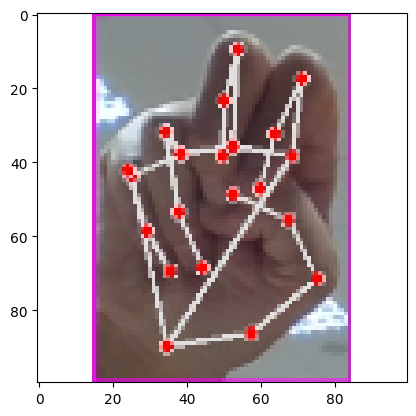

Image shape: (32, 100, 100, 3)
Label shape: (32, 24)
5


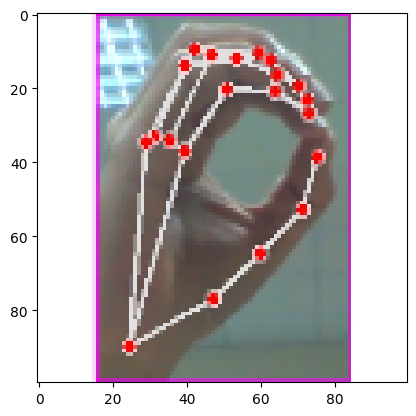

Image shape: (32, 100, 100, 3)
Label shape: (32, 24)
9


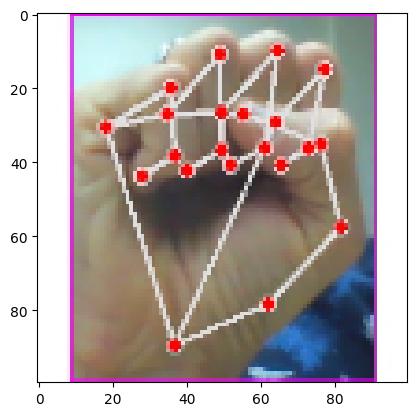

Image shape: (32, 100, 100, 3)
Label shape: (32, 24)
8


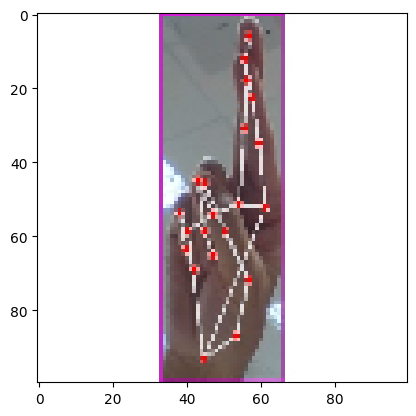

In [37]:
# images, labels = next(train_data)
# print(labels)
    
def random_image_plot(train_data, n):

    images, labels = next(train_data)
    # `images` is a batch of images
    # `labels` is a batch of corresponding labels
    # Perform desired operations with the images and labels
    # Example: Printing the shape of the images and labels
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)
    plt.imshow(images[n])
    print(np.argmax(labels[n]))
    
    return
    
random_image_plot(test_data_100, 10)
plt.show()
random_image_plot(test_data_100, 5)
plt.show()
random_image_plot(test_data_100, 15)
plt.show()
random_image_plot(test_data_100, 20)
plt.show()


In [6]:
es = EarlyStopping(patience=5, restore_best_weights=True)

model_vgg16_100m = initiliaze_model_vgg16(100, 100, 3, 24)

epochs = 12

history_vgg16_100m = model_vgg16_100m.fit(
                    train_data_100m,
                    validation_data = val_data_100m,
                    epochs=epochs,
                    callbacks=[es],
                    verbose=1)

Epoch 1/12


2023-05-28 17:24:36.750443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [55222]
	 [[{{node Placeholder/_4}}]]
2023-05-28 17:24:36.750747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [55222]
	 [[{{node Placeholder/_0}}]]


1726/1726 [==============================] - ETA: 0s - loss: 2.0299 - accuracy: 0.4182

2023-05-28 18:02:47.839067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [23666]
	 [[{{node Placeholder/_4}}]]
2023-05-28 18:02:47.844853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [23666]
	 [[{{node Placeholder/_4}}]]


1726/1726 [==============================] - 2986s 2s/step - loss: 2.0299 - accuracy: 0.4182 - val_loss: 0.7662 - val_accuracy: 0.7702
Epoch 2/12
1726/1726 [==============================] - 2792s 2s/step - loss: 0.7071 - accuracy: 0.7789 - val_loss: 0.2572 - val_accuracy: 0.9124
Epoch 3/12
1726/1726 [==============================] - ETA: 0s - loss: 0.3870 - accuracy: 0.8814

KeyboardInterrupt: 

## Model Initialization with Pre-trained Model ResNet50

In [60]:
def initialize_model_resn50(image_width, image_height, no_chans, n_classes):
    #Initialising ResNet50 
    basemodel_resnet = tflow.keras.applications.ResNet50(input_shape=(image_width,image_height,no_chans),include_top=False,weights='imagenet')
    
    #don't train existing weights for resnet50
    for layer in basemodel_resnet.layers:
        layer.trainable = False
    # basemodel_resnet.trainable = False
    
    # # Create a new model with the scaling preprocessing function
    # input_shape = (image_width,image_height,no_chans)
    # inputs = tflow.keras.Input(shape=input_shape)
    
    # # Scale input tensor X using ResNet50's preprocess_input function
    # X = inputs.map(lambda x, y: (tflow.keras.applications.resnet50.preprocess_input(x), y))
     
    # #Add the other necessary layers for pre-trained model   
    # classifier = basemodel_resnet(X) #head mode 
    # classifier = Flatten()(classifier) #adding layer of flatten
    # classifier = Dense(units=512, activation='relu')(classifier)
    # classifier = Dense(units=256, activation='relu')(classifier)
    # classifier = Dense(units=128, activation='relu')(classifier)
    # classifier = Dropout(0.2)(classifier)
    # classifier = Dense(units=n_classes, activation='softmax')(classifier)
    
    # #Build and compile the model
    # model = Model(inputs = basemodel_resnet.input , outputs = classifier)
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Alternative way to add the other necessary layers for pre-trained model 
    model = Sequential()
    model.add(basemodel_resnet)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=n_classes, activation='softmax'))

    #Build and compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [61]:
train_100_pre = train_data_100.map(lambda x, y: (tflow.keras.applications.resnet50.preprocess_input(x), y))
val_100_pre = val_data_100.map(lambda x, y: (tflow.keras.applications.resnet50.preprocess_input(x), y))
test_100_pre = test_data_100.map(lambda x, y: (tflow.keras.applications.resnet50.preprocess_input(x), y))

es = EarlyStopping(patience=5, restore_best_weights=True)

epochs = 10

model_resnet50_100 = initialize_model_resn50(100,100,3,24)

history_resnet50_100 = model_resnet50_100.fit(
                            train_100_pre,
                            validation_data = val_100_pre,
                            epochs=epochs,
                            callbacks=[es],
                            verbose=1)

Epoch 1/10


2023-05-27 17:14:48.788632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13440]
	 [[{{node Placeholder/_4}}]]
2023-05-27 17:14:48.789475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13440]
	 [[{{node Placeholder/_4}}]]


420/420 [==============================] - ETA: 0s - loss: 0.9891 - accuracy: 0.7554

2023-05-27 17:20:52.115711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5759]
	 [[{{node Placeholder/_0}}]]
2023-05-27 17:20:52.117016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5759]
	 [[{{node Placeholder/_4}}]]


420/420 [==============================] - 453s 1s/step - loss: 0.9891 - accuracy: 0.7554 - val_loss: 0.3256 - val_accuracy: 0.8946
Epoch 2/10
420/420 [==============================] - 501s 1s/step - loss: 0.2500 - accuracy: 0.9222 - val_loss: 0.1798 - val_accuracy: 0.9462
Epoch 3/10
420/420 [==============================] - 464s 1s/step - loss: 0.1547 - accuracy: 0.9510 - val_loss: 0.2076 - val_accuracy: 0.9408
Epoch 4/10
420/420 [==============================] - 427s 1s/step - loss: 0.1165 - accuracy: 0.9661 - val_loss: 0.2368 - val_accuracy: 0.9302
Epoch 5/10
420/420 [==============================] - 402s 958ms/step - loss: 0.1337 - accuracy: 0.9651 - val_loss: 0.2414 - val_accuracy: 0.9360
Epoch 6/10
420/420 [==============================] - 405s 964ms/step - loss: 0.0940 - accuracy: 0.9742 - val_loss: 0.1632 - val_accuracy: 0.9571
Epoch 7/10
420/420 [==============================] - 398s 948ms/step - loss: 0.0562 - accuracy: 0.9842 - val_loss: 0.1885 - val_accuracy: 0.9677
E

In [63]:
model_resnet50_100_scores = model_resnet50_100.evaluate(test_100_pre)

print(f'ResNet50 pre-trained model loss: {model_resnet50_100_scores[0]:.4f}')
print(f'ResNet50 pre-trained model accuracy: {model_resnet50_100_scores[1]:.4f}')

2023-05-27 18:36:29.132352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5759]
	 [[{{node Placeholder/_0}}]]
2023-05-27 18:36:29.133559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5759]
	 [[{{node Placeholder/_0}}]]


30/30 [==============================] - 16s 510ms/step - loss: 0.1534 - accuracy: 0.9719
ResNet50 pre-trained model loss: 0.1534
ResNet50 pre-trained model accuracy: 0.9719


In [64]:
# Save the model
models.save_model(model_resnet50_100, "raw_data/transfer_models/model_resnet50_100_landmark")

2023-05-27 18:37:08.970700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-05-27 18:37:14.931029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: raw_data/transfer_models/model_resnet50_100_landmark/assets


INFO:tensorflow:Assets written to: raw_data/transfer_models/model_resnet50_100_landmark/assets


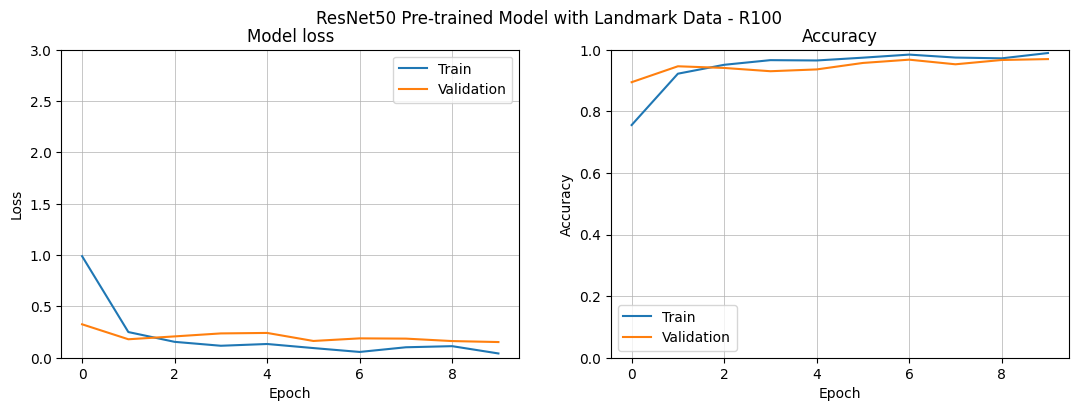

In [65]:
plot_loss_accuracy(history_resnet50_100, 'ResNet50 Pre-trained Model with Landmark Data - R100')

In [67]:
model_resnet50_100.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               16777728  
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 24)                3